In [39]:
% matplotlib inline

import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from IPython import display

In [40]:
class CreepBlockState(object):
    def __init__(self, num_creep, creep_size, creep_speed, init_creep_location, block_time, hero_size, hero_speed, 
                 hero_turn_speed, init_hero_location):
        self.hero = Hero(hero_size, hero_speed, hero_turn_speed, init_hero_location)
        init_creep_locations = []
        for i in range(num_creep):
            x = 0 - (num_creep - 1) / 2.0 * creep_size + i * creep_size
            init_creep_location = np.array([x, 0])
            init_creep_locations.append(init_creep_location)
        self.creeps = []
        for i in range(num_creep):
            creep = Creep(creep_size, creep_speed, init_creep_locations[i], block_time)
            self.creeps.append(creep)
        self.reset()
        
    def reset(self):
        self.num_steps = 0
        self.hero.reset()
        for i in range(len(self.creeps)):
            self.creeps[i].reset()

    def step(self, hero_action):
        self.num_steps = self.num_steps + 1
        self.hero.update_hero_status(hero_action)
        for i in range(len(self.creeps)):
            self.creeps[i].update_creep_status(self.hero)
    
class Hero(object):
    def __init__(self, hero_size, hero_speed, hero_turn_speed, init_hero_location):
        self.size = hero_size
        self.speed = hero_speed
        self.turn_speed = hero_turn_speed
        self.init_hero_location = init_hero_location
        self.init_hero_angle = 90
        self.reset()
    
    def reset(self):
        self.location = np.array([0, self.init_hero_location])
        self.angle = self.init_hero_angle
    
    def parse_hero_action(self, hero_action):
        assert np.count_nonzero(hero_action) == 1, \
            'The hero contain 4 actions [move, turn right, turn left, stay]. One of them must be 1, others must be 0.'
        velocity = hero_action[0] * self.speed
        angle_velocity = hero_action[1] * self.turn_speed - hero_action[2] * self.turn_speed
        return velocity, angle_velocity

    def update_hero_status(self, hero_action):
        velocity, angle_velocity = self.parse_hero_action(hero_action)
        self.angle = self.angle + angle_velocity
        velocity_2d = np.array([velocity * np.cos(self.angle * np.pi / 180), velocity * np.sin(self.angle * np.pi / 180)])
        self.location = self.location + velocity_2d
    
class Creep(object):
    def __init__(self, creep_size, creep_speed, init_creep_location, block_time):     
        self.size = creep_size
        self.speed = creep_speed
        self.init_creep_location = init_creep_location
        self.init_creep_angle = 90
        self.block_time = 2
        self.reset()
        
    def reset(self):
        self.location = np.array([self.init_creep_location[0], self.init_creep_location[1]])
        self.angle = self.init_creep_angle
        self.blocked = False
        self.blocked_count = 0

    @staticmethod
    def dist(x,y):   
        return np.sqrt(np.sum((x-y)**2))

    def update_creep_status(self, hero):
        # First if the creep is already blocked, then it will stuck a little bit
        if self.blocked:
            self.blocked_count = self.blocked_count - 1
            if self.blocked_count == 0:
                self.blocked = False
            return
        # If the creep is not blocked, then check if it will be blocked in the new location
        new_location = self.location[1] + self.speed
        if self.dist(new_location, hero.location) < self.size + hero.size:
            self.blocked = True
            self.blocked_count = self.block_time
        else:
            self.location[1] = new_location

In [41]:
class CreepBlockSimulator(object):
    def __init__(self, num_creep=4, creep_size=1, creep_speed=1, init_creep_location=0, block_time=2,
                 hero_size=1.5, hero_speed=1.5, hero_turn_speed=30, init_hero_location=3, 
                 display=True, display_speed=0.5):
        self.state = CreepBlockState(num_creep, creep_size, creep_speed, init_creep_location, block_time,
                                    hero_size, hero_speed, hero_turn_speed, init_hero_location)
        self.display = display
        self.display_speed = display_speed
        self.reset()

    def reset(self):
        self.state.reset()
        
    def step(self, hero_action):
        old_state = copy.deepcopy(self.state)
        self.state.step(hero_action)
        reward = self.get_reward(old_state)
        game_over = self.is_game_over()
        if self.display:
            self.visualize()
        return self.state, reward, game_over
        
    @staticmethod
    def dist(x,y):   
        return np.sqrt(np.sum((x-y)**2))
    
    def get_reward(self, old_state):
        reward = 0
        for i in range(len(self.state.creeps)):
            old_location = old_state.creeps[i].location
            location = self.state.creeps[i].location
            move_dist = self.dist(old_location, location)
            reward = reward - move_dist / self.state.creeps[i].speed
        return reward
    
    def is_game_over(self):
        game_over = False
        if self.state.num_steps >= 1000:
            game_over = True
        total_dist = 0
        hero_location = self.state.hero.location
        for i in range(len(self.state.creeps)):
            creep_location = self.state.creeps[i].location
            creep_hero_dist = self.dist(creep_location, hero_location)
            total_dist = total_dist + creep_hero_dist
        if total_dist > 10 * len(self.state.creeps):
            game_over = True
        return game_over
    
    def visualize(self):
        ax = plt.gca()
        ax.cla()
        ax.axis('scaled')
        hero = self.state.hero
        circ = plt.Circle([hero.location[0], hero.location[1]], hero.size / 2.0, color='r')
        ax.add_artist(circ)
        dx = hero.size / 2.0 * np.cos(hero.angle * np.pi / 180)
        dy = hero.size / 2.0 * np.sin(hero.angle * np.pi / 180)
        hw = hero.size / 2.0
        hl = hero.size / 2.0 / 2.0
        arr = plt.arrow(hero.location[0], hero.location[1], dx, dy, head_width=hw, head_length=hl, fc='r', ec='k')
        ax.add_artist(arr)
        for creep in self.state.creeps:
            circ = plt.Circle((creep.location[0], creep.location[1]), creep.size / 2.0, color='g')
            ax.add_artist(circ)
            dx = creep.size / 2.0 * np.cos(creep.angle * np.pi / 180)
            dy = creep.size / 2.0 * np.sin(creep.angle * np.pi / 180)
            hw = creep.size / 2.0
            hl = creep.size / 2.0 / 2.0
            arr = plt.arrow(creep.location[0], creep.location[1], dx, dy, head_width=hw, head_length=hl, fc='g', ec='k')
            ax.add_artist(arr)
        ax.axis((-3, 3, -1, 10))
        ax.grid()
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(self.display_speed)

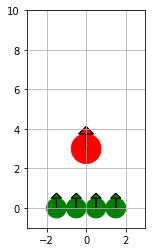

In [42]:
env = CreepBlockSimulator()
env.reset()
env.visualize()
plt.close()

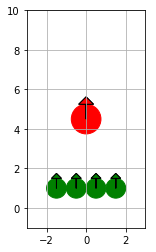

In [43]:
hero_action = np.zeros(4,)
hero_action[0] = 1
state, reward, game_over = env.step(hero_action)
plt.close()

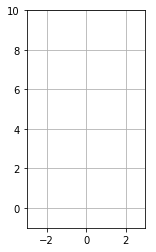

In [44]:
for i in range(10):
    hero_action = np.zeros(4,)
    hero_action[0] = 1
    state, reward, game_over = env.step(hero_action)
plt.close()